这里我以苹果10年的股票历史价格和雅虎财经的回报为例，当然你可以使用任何数据。

In [1]:
import pandas as pd 
import yfinance as yf
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300

df = yf.download('AAPL',
                 start = '1999-12-31',
                 end= '2010-12-31')

[*********************100%***********************]  1 of 1 completed


由于我们只关心回报，因此DataFrame (d1)创建了一个新的来保存调整后的价格和回报。

In [2]:
d1 = pd.DataFrame(df['Adj Close'])
d1.rename(columns={'Adj Close':'adj_close'}, inplace=True)
d1['simple_rtn']=d1.adj_close.pct_change()
d1.head()

,adj_close,simple_rtn
Date,,
1999-12-31,0.781300,NaN
2000-01-03,0.850643,0.088753
2000-01-04,0.778926,-0.084310
2000-01-05,0.790324,0.014633
2000-01-06,0.721930,-0.086539


In [3]:
d1_mean = d1['simple_rtn'].agg(['mean', 'std'])

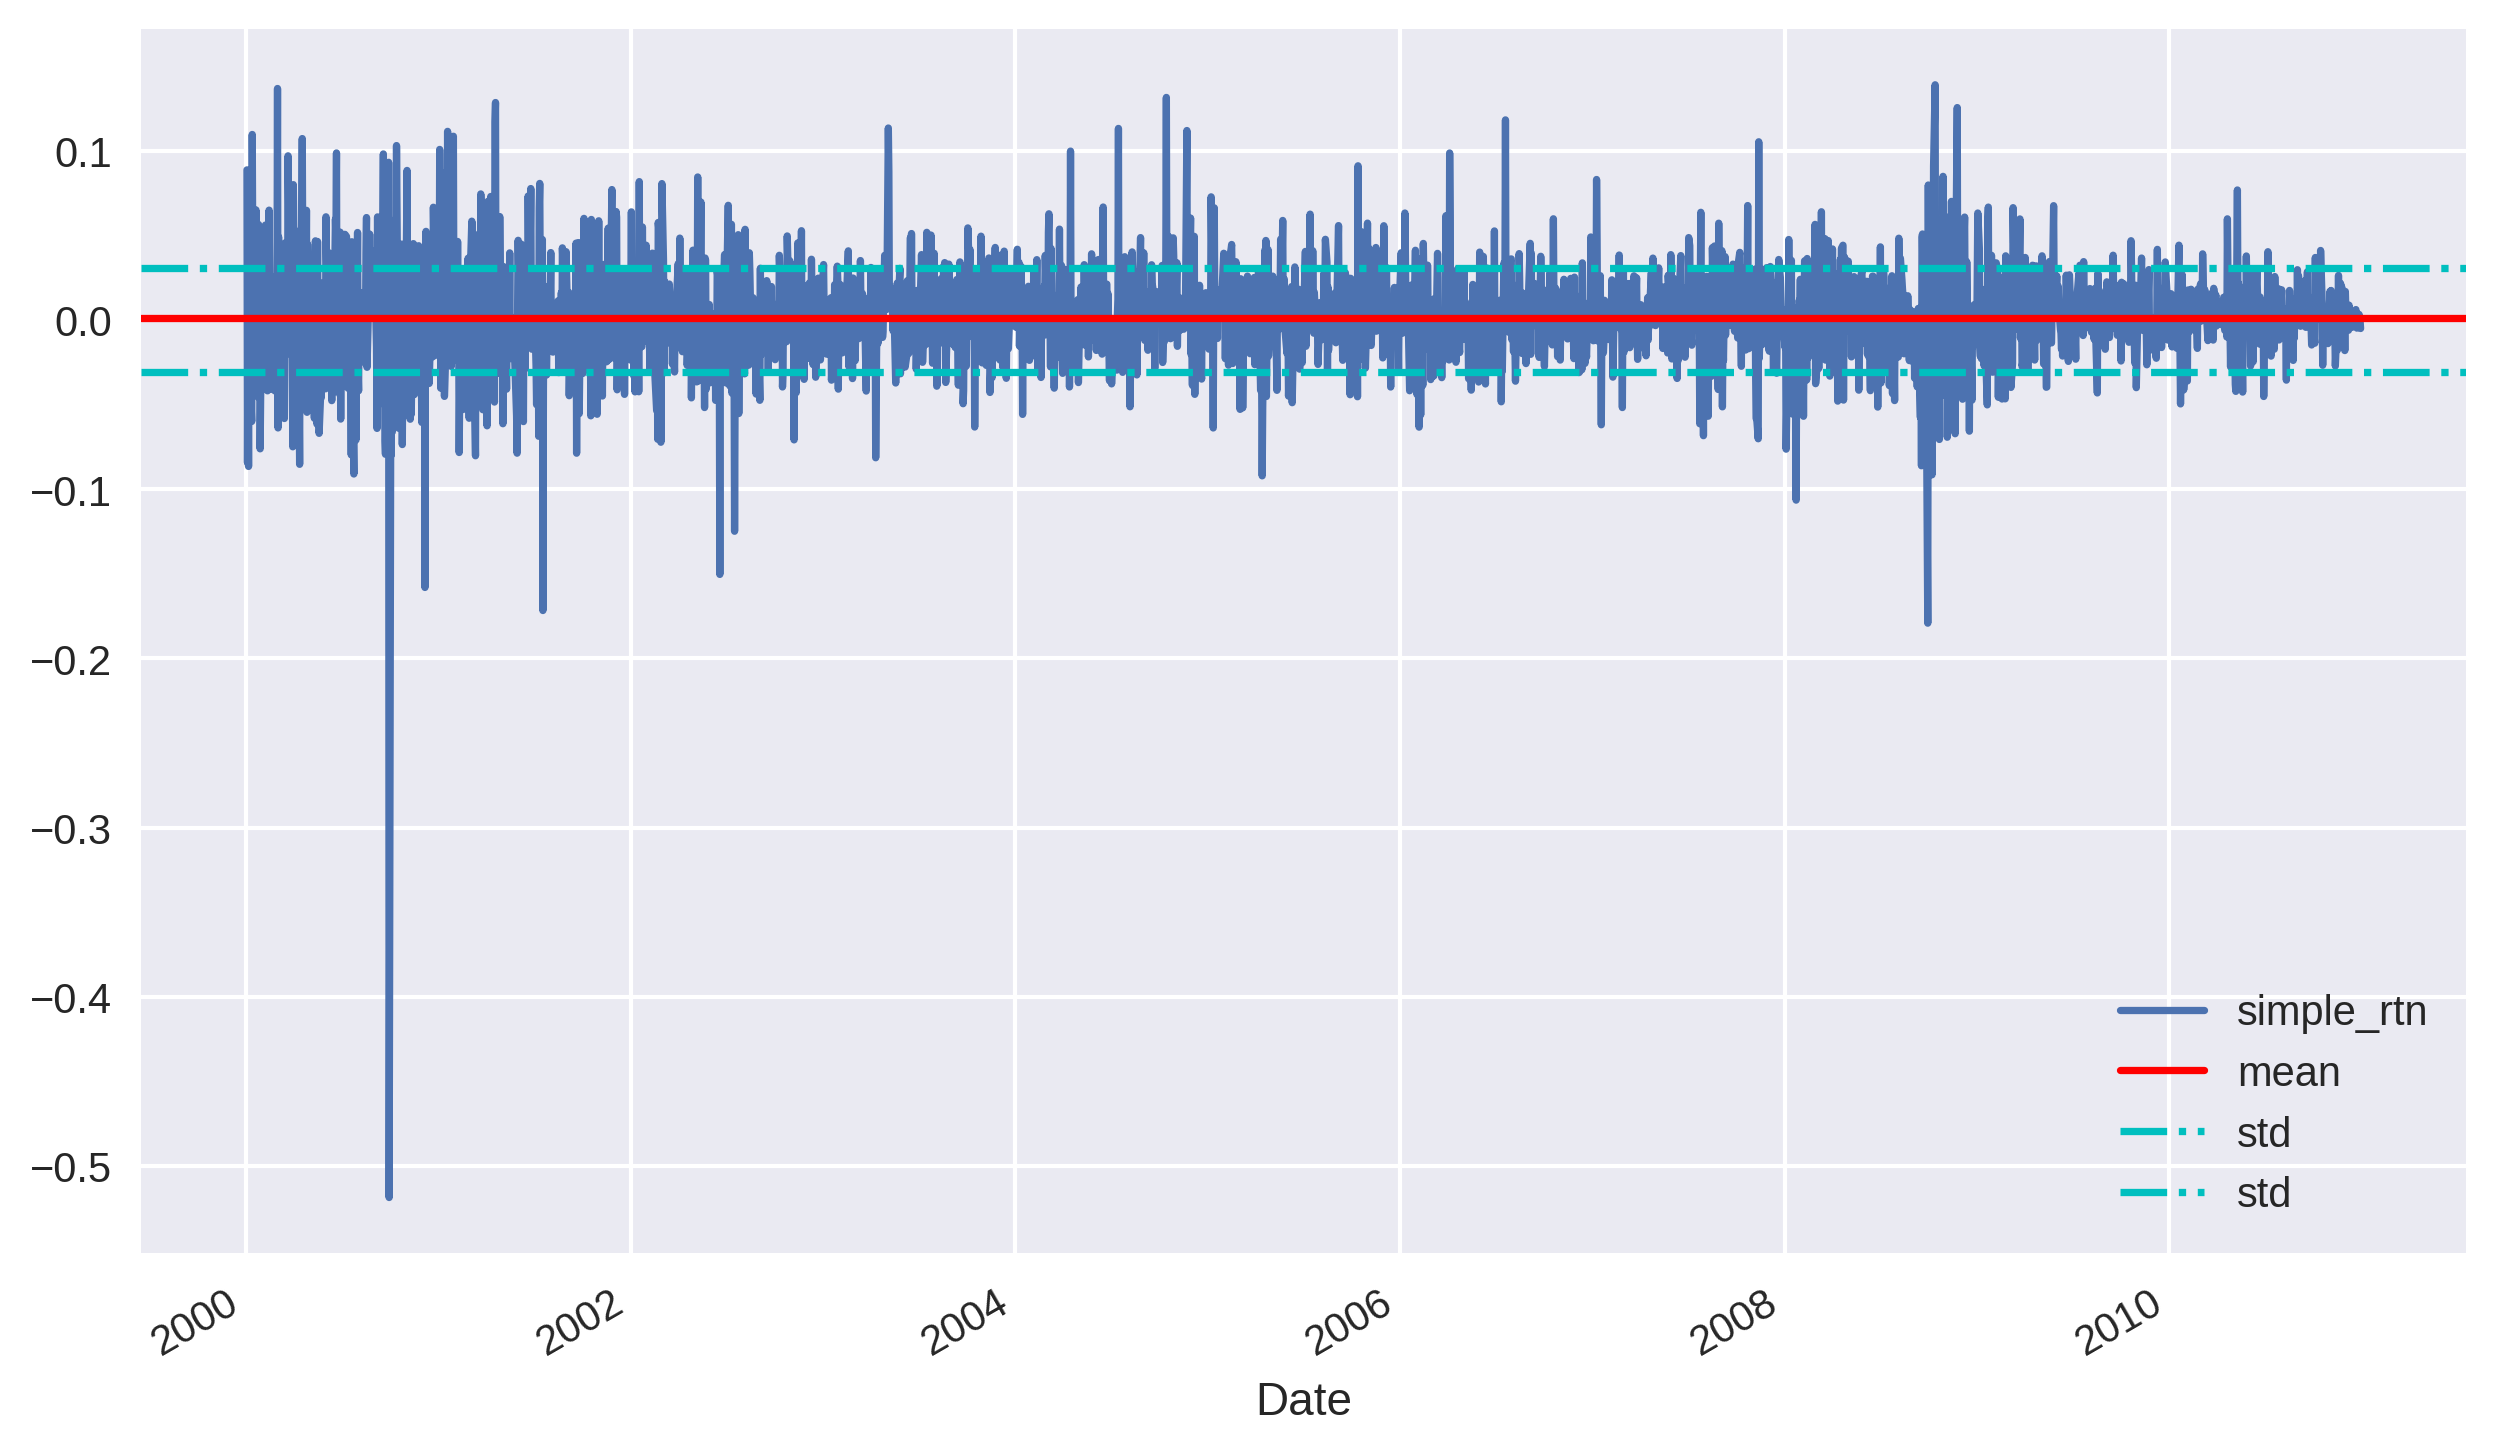

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
d1['simple_rtn'].plot(label='simple_rtn', legend=True, ax = ax)
plt.axhline(y=d1_mean.loc['mean'], c='r', label='mean')
plt.axhline(y=d1_mean.loc['std'], c='c', linestyle='-.',label='std')
plt.axhline(y=-d1_mean.loc['std'], c='c', linestyle='-.',label='std')
plt.legend(loc='lower right')

如果使用3倍std替代呢？

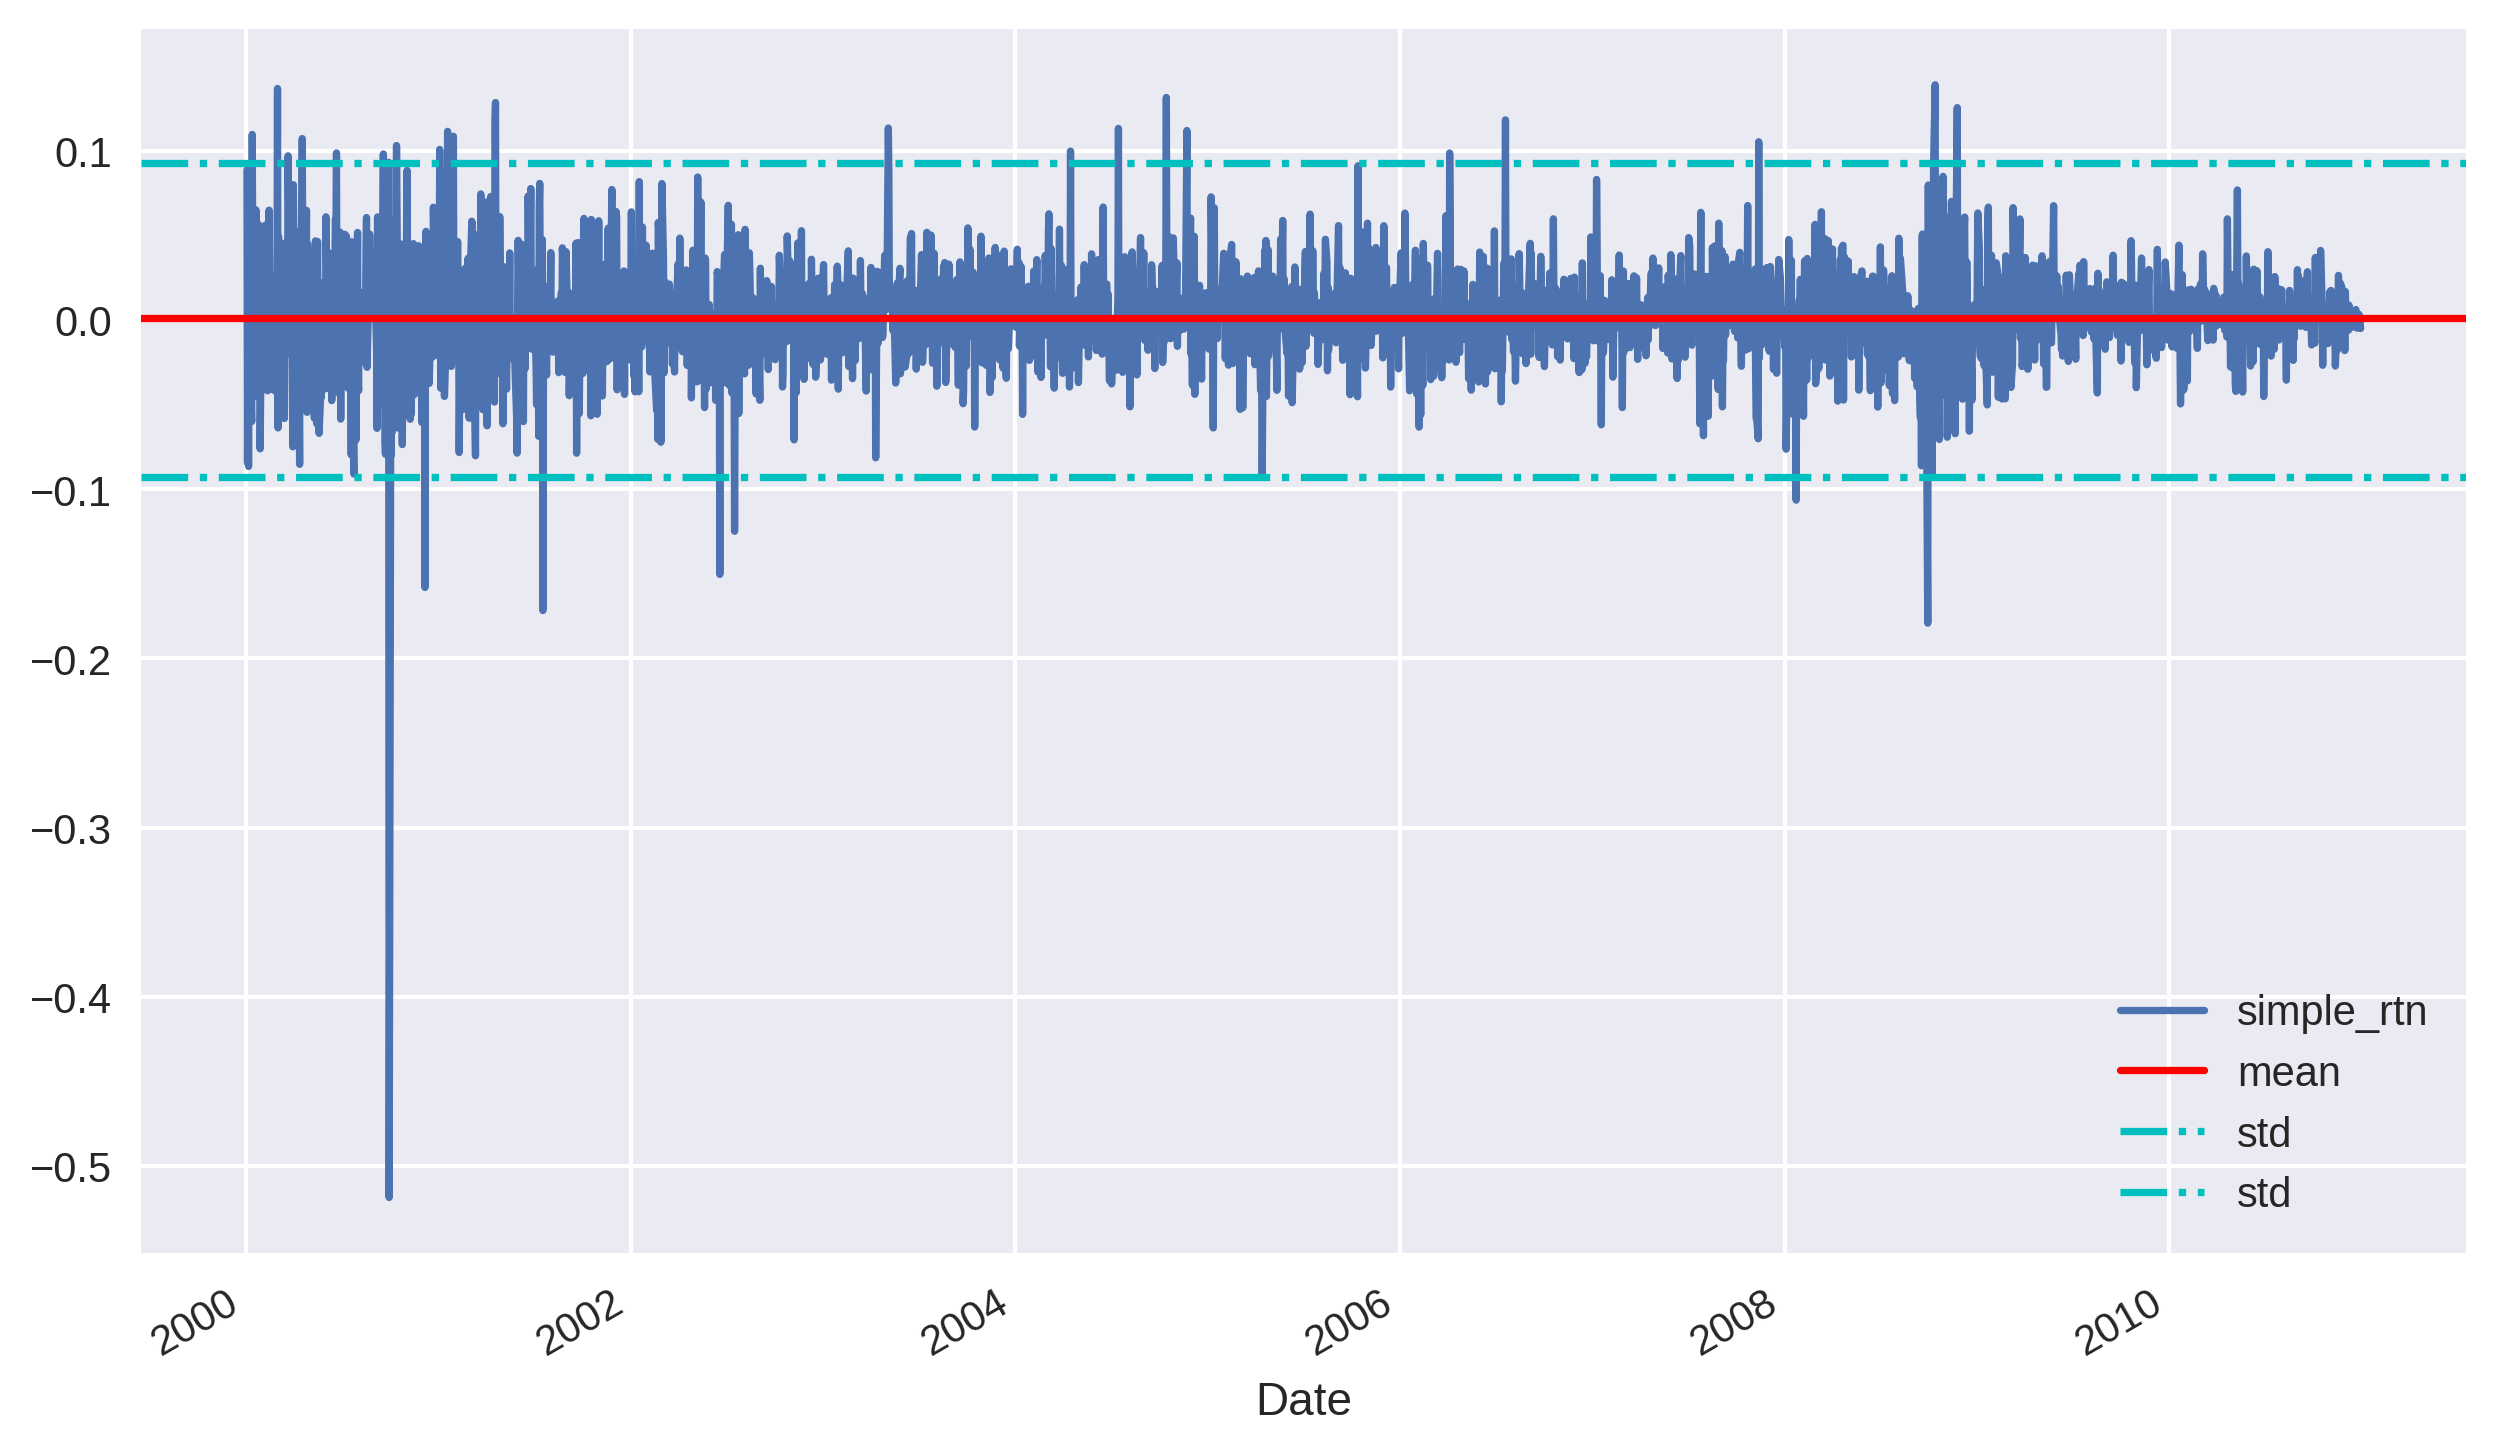

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
d1['simple_rtn'].plot(label='simple_rtn', legend=True, ax = ax)
plt.axhline(y=d1_mean.loc['mean'], c='r', label='mean')
plt.axhline(y=3*d1_mean.loc['std'], c='c', linestyle='-.',label='std')
plt.axhline(y=-3*d1_mean.loc['std'], c='c', linestyle='-.',label='std')
plt.legend(loc='lower right')

In [6]:
mu = d1_mean.loc['mean']
sigma = d1_mean.loc['std']
n_sigmas=3 # 3倍设置为边界

cond = (d1['simple_rtn'] > mu + sigma * n_sigmas) | (d1['simple_rtn'] < mu - sigma * n_sigmas)
d1['outlier'] = np.where(cond, 1, 0)
d1.head()

,adj_close,simple_rtn,outlier
Date,,,
1999-12-31,0.781300,NaN,0
2000-01-03,0.850643,0.088753,0
2000-01-04,0.778926,-0.084310,0
2000-01-05,0.790324,0.014633,0
2000-01-06,0.721930,-0.086539,0


In [7]:
d1.outlier.value_counts()

0    2737
1      30
Name: outlier, dtype: int64

我们可以把那些离群值挑出来，放到另一个里DataFrame，然后显示在图表中

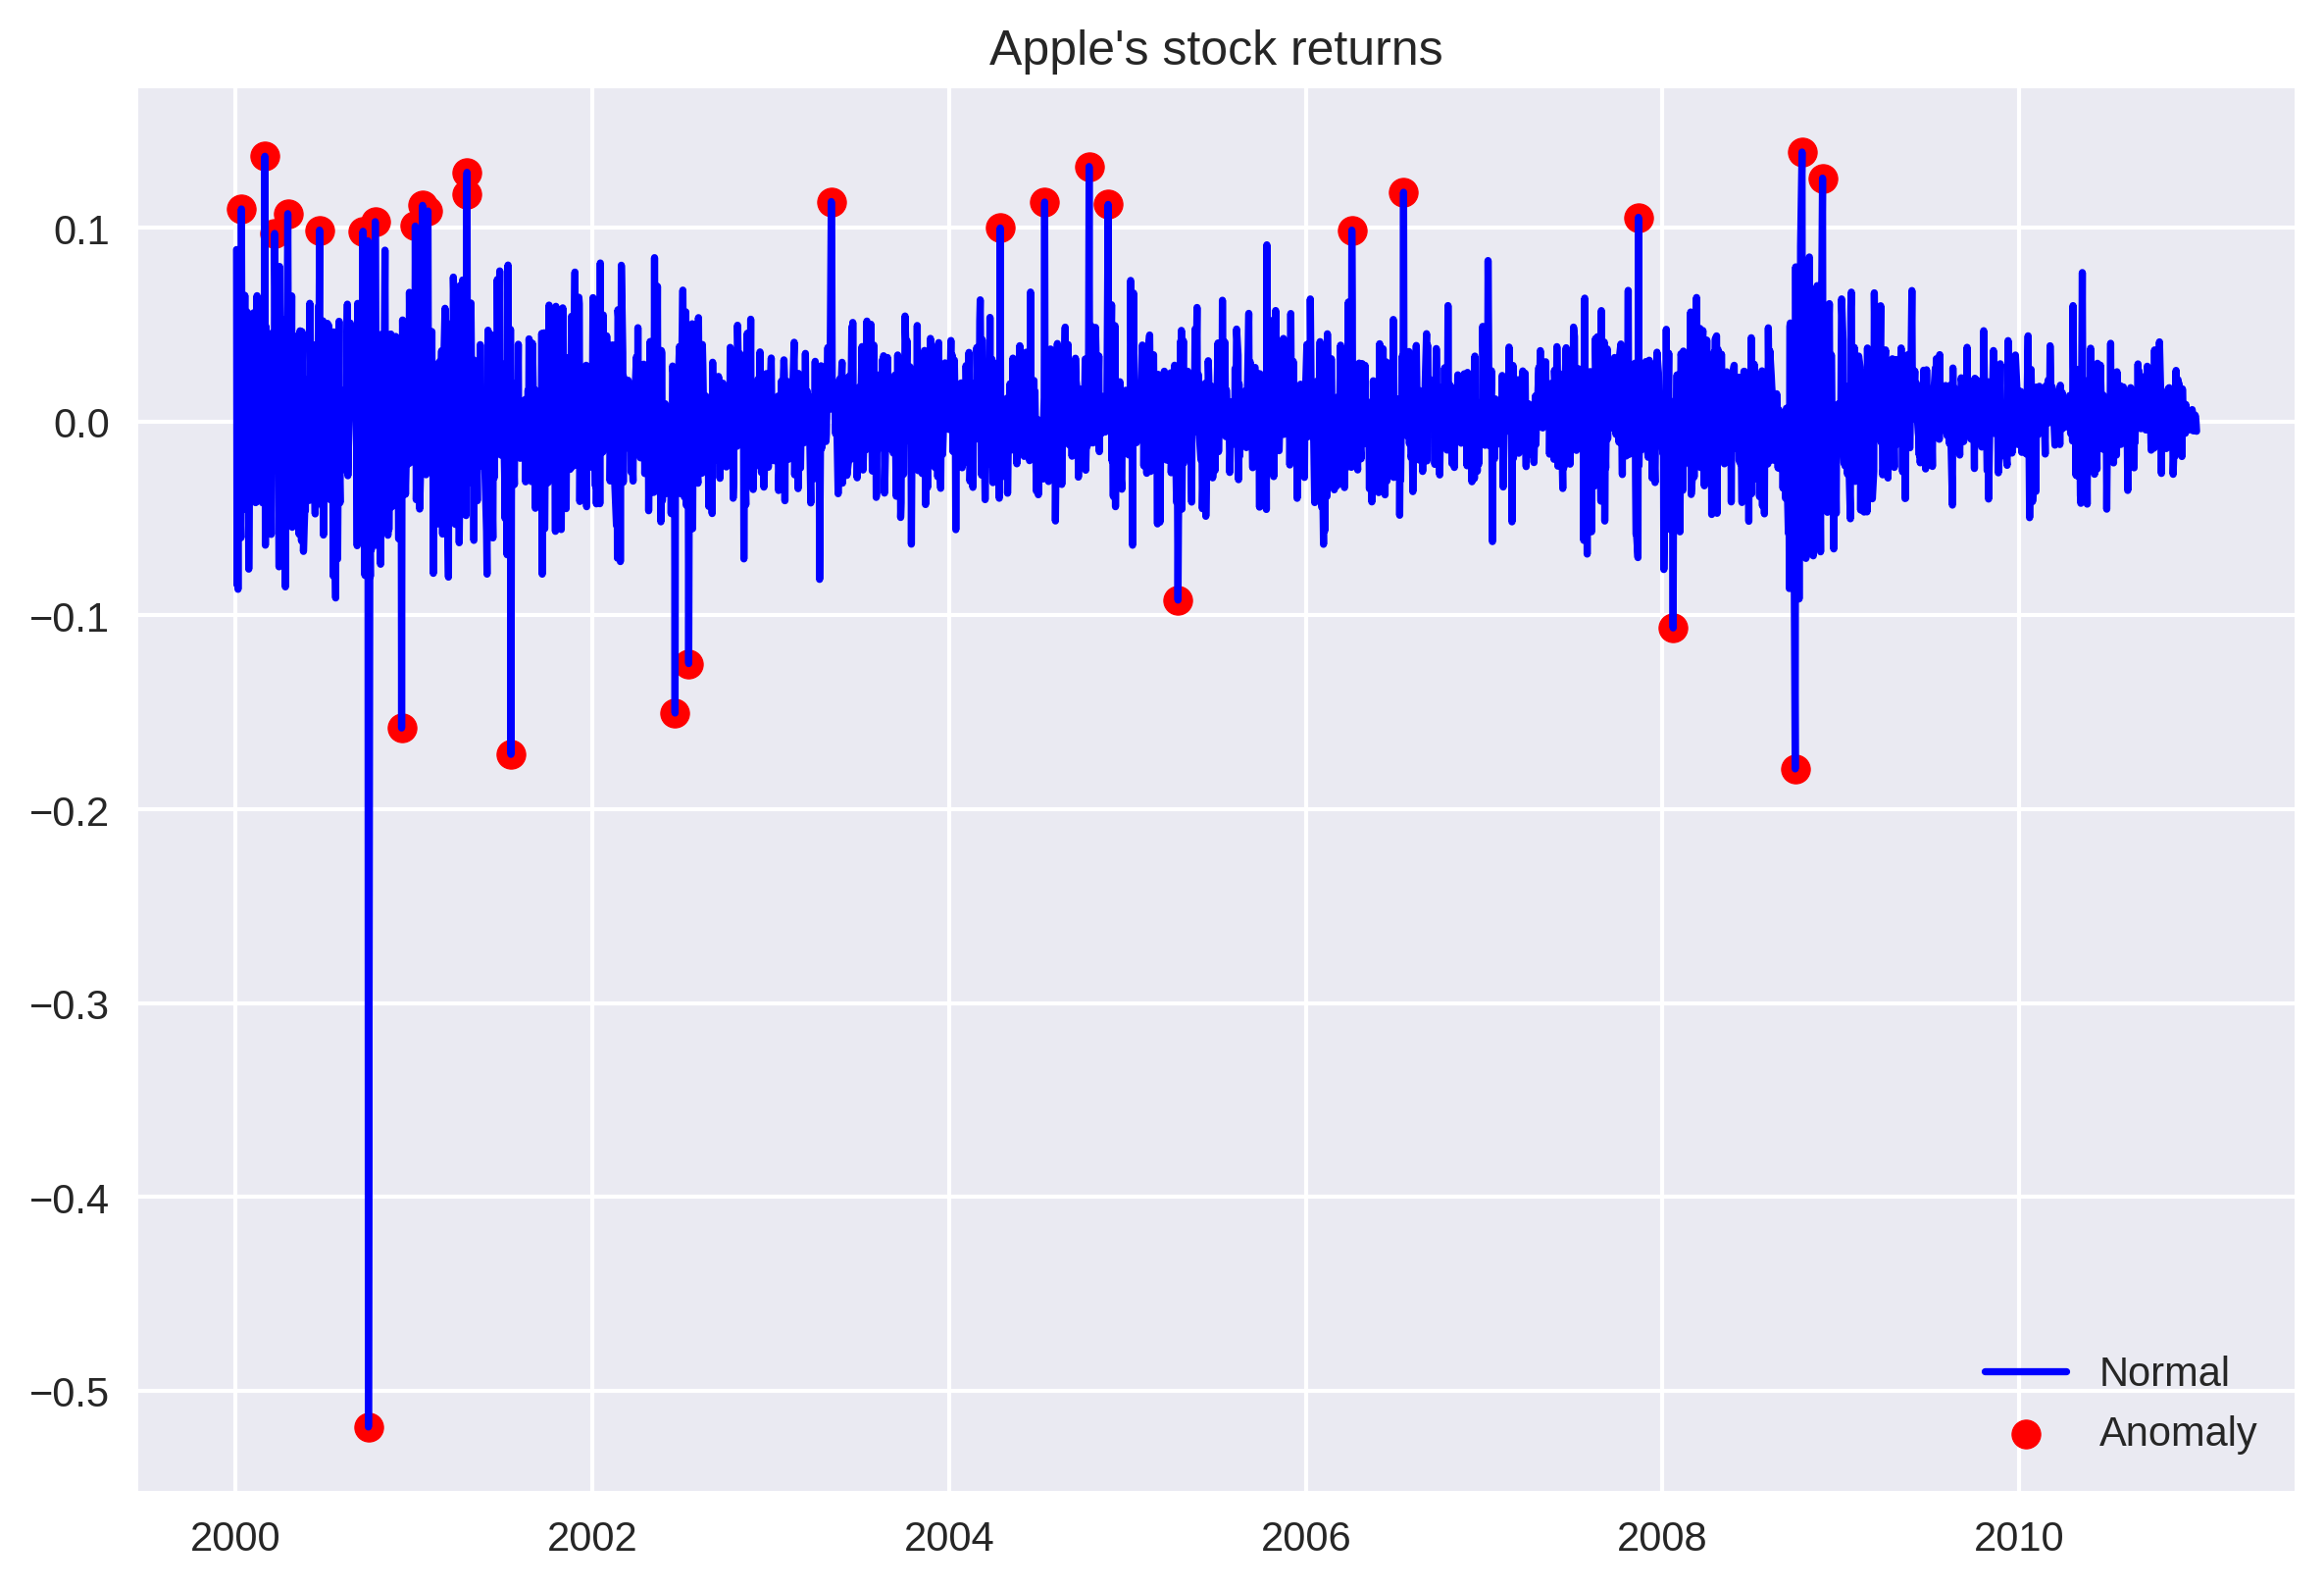

In [8]:
outliers = d1.loc[d1['outlier'] == 1, ['simple_rtn']]
fig, ax = plt.subplots()
ax.plot(d1.index, d1.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')
plt.tight_layout()

plt.show()

Winsorization是用较小的数据值替换指定数量的极端值的过程。它是以工程师转型生物统计学家查尔斯·P·温索尔（1895-1951）的名字命名的。其效果类似于信号处理中的裁剪。

一种典型的策略是将所有异常值设置为数据的指定百分位数；例如，95％的Winsorization会将所有低于第5个百分位数的数据设置为第5个百分位数，并将高于第95个百分位数的数据设置为第95个百分位数。可以在pandas中使用clip()函数实现这个过程。

In [9]:
outlier_cutoff = 0.01
d = d1.pipe(lambda x:x.clip(lower=x.quantile(outlier_cutoff),
                        upper=x.quantile(1-outlier_cutoff),
                        axis=1))
d

,adj_close,simple_rtn,outlier
Date,,,
1999-12-31,0.781300,NaN,0
2000-01-03,0.850643,0.087088,0
2000-01-04,0.778926,-0.071702,0
2000-01-05,0.790324,0.014633,0
2000-01-06,0.721930,-0.071702,0
...,...,...,...
2010-12-23,9.611219,-0.004798,0
2010-12-27,9.611219,0.003337,0
2010-12-28,9.611219,0.002433,0


在进行Winsorization操作后，DataFrame的形状（即列数和行数）不会改变，但是其中的数据值会发生变化。具体来说，原始数据中低于第5个百分位数的数值会被替换为第5个百分位数，而高于第95个百分位数的数值会被替换为第95个百分位数。

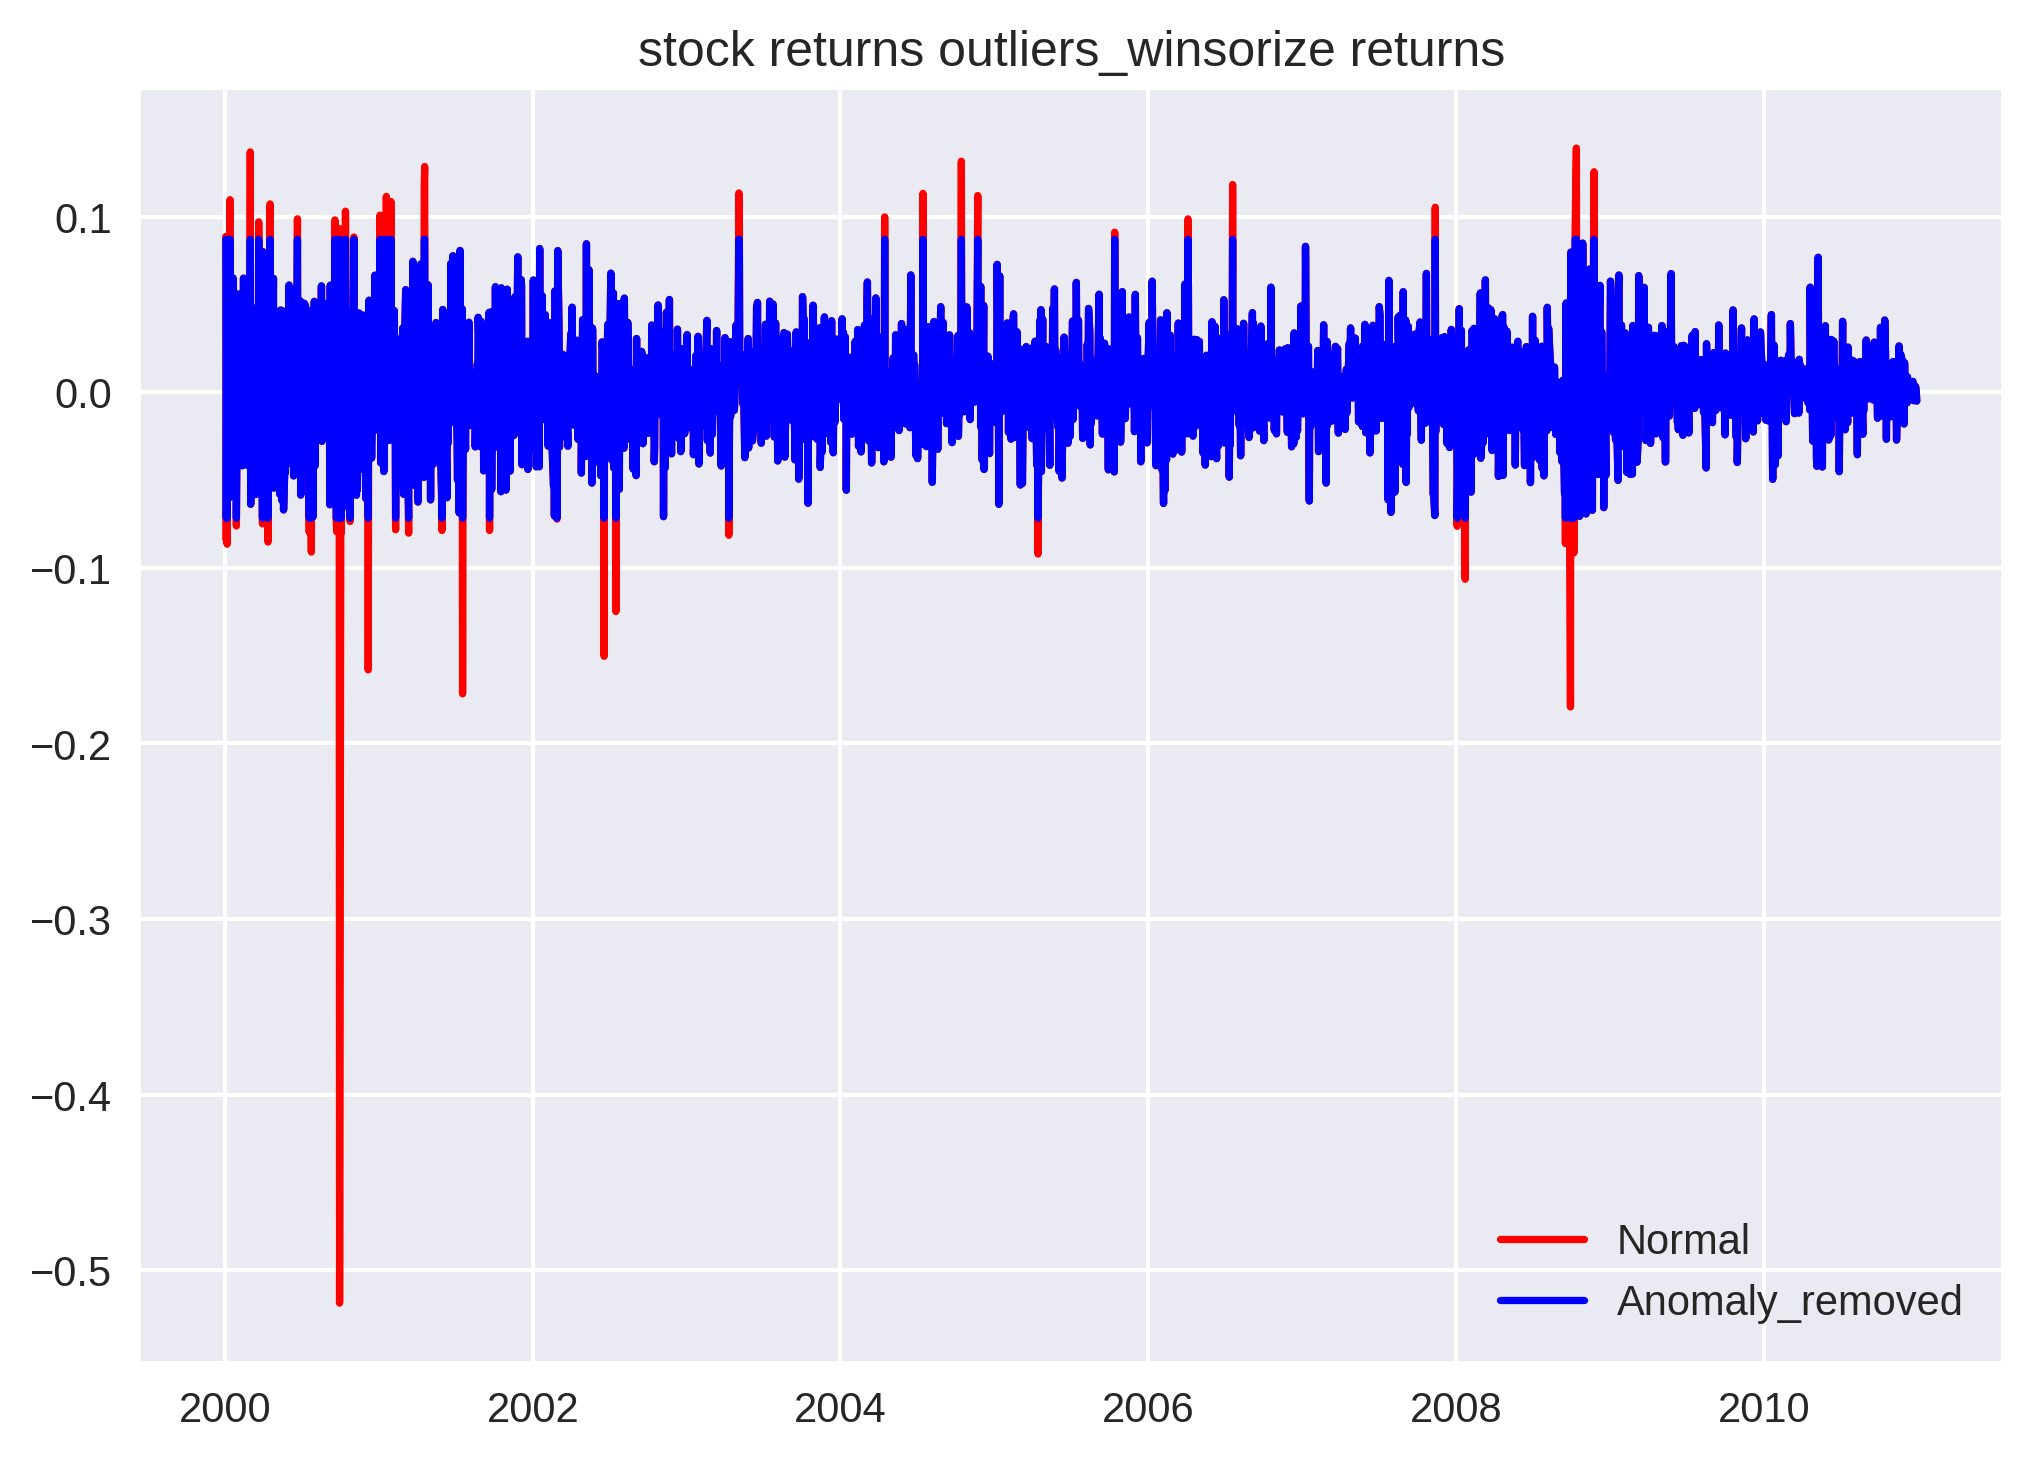

In [10]:
fig, ax = plt.subplots()
ax.plot(d1.index, d1.simple_rtn, 
        color='red', label='Normal')
ax.plot(d.index, d.simple_rtn, 
        color='blue', label='Anomaly_removed')
ax.set_title("stock returns outliers_winsorize returns")
ax.legend(loc='lower right');